# Automatic Image Quality Assessment

In [0]:
!pip install --user opencv-python
!pip install --user libsvm

In [0]:
import collections
from itertools import chain
import urllib.request as request
import pickle 

import numpy as np

import scipy.signal as signal
import scipy.ndimage.filters as filters
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

import cv2

from libsvm import svmutil

In [0]:
def normalize_kernel(kernel):
  return kernel / np.sum(kernel)

def gaussian_kernel2d(n, sigma):
  Y, X = np.indices((n, n)) - int(n/2)
  gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2)) 
  return normalize_kernel(gaussian_kernel)

def local_mean(image, kernel):
  return signal.convolve2d(image, kernel, 'same')

In [0]:
def local_deviation(image, local_mean, kernel):
   "Vectorized approximation of local deviation"
   sigma = image ** 2
   sigma = signal.convolve2d(sigma, kernel, 'same')
   return np.sqrt(np.abs(local_mean ** 2 - sigma))

In [0]:
def calculate_mscn_coefficients(image, kernel_size=6, sigma=7/6):
  C = 1/255
  kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
  local_mean = signal.convolve2d(image, kernel, 'same')
  local_var = local_deviation(image, local_mean, kernel)
  
  return (image - local_mean) / (local_var + C)

In [0]:
def generalized_gaussian_dist(x, alpha, sigma):
  beta = sigma * np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))

  coefficient = alpha / (2 * beta() * special.gamma(1 / alpha))
  return coefficient * np.exp(-(np.abs(x) / beta) ** alpha)

In [0]:
def calculate_pair_product_coefficients(mscn_coefficients):
  return collections.OrderedDict({
      'mscn': mscn_coefficients,
      'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
      'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
      'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
      'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
      })

In [0]:
def asymmetric_generalized_gaussian(x, nu, sigma_l, sigma_r):
  def beta(sigma):
    return sigma * np.sqrt(special.gamma(1 / nu) / special.gamma(3 / nu))
    
    coefficient = nu / ((beta(sigma_l) + beta(sigma_r)) * special.gamma(1 / nu))
    f = lambda x, sigma: coefficient * np.exp(-(x / beta(sigma)) ** nu)
    
    return np.where(x < 0, f(-x, sigma_l), f(x, sigma_r))

In [0]:
def asymmetric_generalized_gaussian_fit(x):
  def estimate_phi(alpha):
    numerator = special.gamma(2 / alpha) ** 2
    denominator = special.gamma(1 / alpha) * special.gamma(3 / alpha)
    return numerator / denominator
    
  def estimate_r_hat(x):
    size = np.prod(x.shape)
    return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)
    
  def estimate_R_hat(r_hat, gamma):
    numerator = (gamma ** 3 + 1) * (gamma + 1)
    denominator = (gamma ** 2 + 1) ** 2
    return r_hat * numerator / denominator
    
  def mean_squares_sum(x, filter = lambda z: z == z):
    filtered_values = x[filter(x)]
    squares_sum = np.sum(filtered_values ** 2)
    return squares_sum / ((filtered_values.shape))
    
  def estimate_gamma(x):
    left_squares = mean_squares_sum(x, lambda z: z < 0)
    right_squares = mean_squares_sum(x, lambda z: z >= 0)
    
    return np.sqrt(left_squares) / np.sqrt(right_squares)
    
  def estimate_alpha(x):
    r_hat = estimate_r_hat(x)
    gamma = estimate_gamma(x)
    R_hat = estimate_R_hat(r_hat, gamma)
    
    solution = optimize.root(lambda z: estimate_phi(z) - R_hat, [0.2]).x
    
    return solution[0]
    
  def estimate_sigma(x, alpha, filter = lambda z: z < 0):
    return np.sqrt(mean_squares_sum(x, filter))
    
  def estimate_mean(alpha, sigma_l, sigma_r):
    return (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))
  
  alpha = estimate_alpha(x)
  sigma_l = estimate_sigma(x, alpha, lambda z: z < 0)
  sigma_r = estimate_sigma(x, alpha, lambda z: z >= 0)
  
  constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
  mean = estimate_mean(alpha, sigma_l, sigma_r)
  
  return alpha, mean, sigma_l, sigma_r

In [0]:
def calculate_brisque_features(image, kernel_size=7, sigma=7/6):
  def calculate_features(coefficients_name, coefficients, accum=np.array([])):
    alpha, mean, sigma_l, sigma_r = asymmetric_generalized_gaussian_fit(coefficients)
    
    if coefficients_name == 'mscn':
      var = (sigma_l ** 2 + sigma_r ** 2) / 2
      return [alpha, var]
      
    return [alpha, mean, sigma_l ** 2, sigma_r ** 2]
  
  mscn_coefficients = calculate_mscn_coefficients(image, kernel_size, sigma)
  coefficients = calculate_pair_product_coefficients(mscn_coefficients)
  
  features = [calculate_features(name, coeff) for name, coeff in coefficients.items()]
  flatten_features = list(chain.from_iterable(features))
  return np.array(flatten_features)

In [0]:
def load_image(url):
  image_stream = request.urlopen(url)
  return skimage.io.imread(image_stream, plugin='pil')

def plot_histogram(x, label):
  n, bins = np.histogram(x.ravel(), bins=50)
  n = n / np.max(n)
  plt.plot(bins[:-1], n, label=label, marker='o')

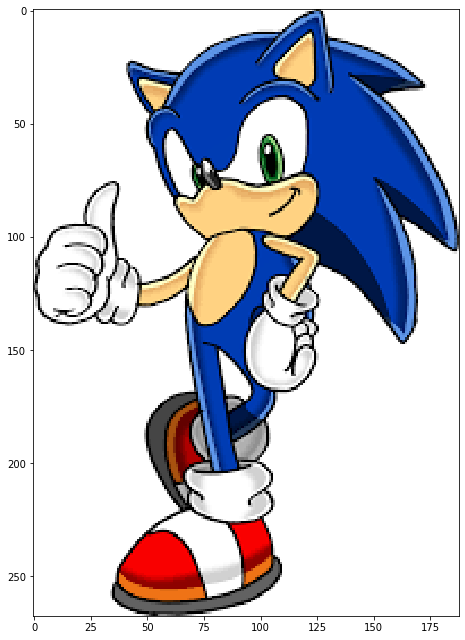

In [0]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 9

url = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAALwAAAEMCAMAAABJKixYAAACB1BMVEX///8AO7QAAAD/0oIAF0b5AABFRUViYmLR0dEAPLPvcxb8/Pxck+UAJG729vYAPLbn5+cAPrz/AAAAOazY2NiOAgDf39//1YTw8PAAOKnj4+PNzc0AMpgAF0VfmOwANqP//8UAJnW8vLwANJ0ALIgAKX7/3IjFxcWwsLD6ynwAMJGioqKRkZFjAQAAFGOrq6v0wnZvb2+oUg/rtGtaWlqCgoLlqWAAEzsAHGg7OzuMjIybm5sAACB6enpNTU2uAAAnJydQg9IvLy/17rdCb7sAABkAETMTExMlO1uUAgDpAACSAgAAAB8AABEAADseHh7GAAAjRo5GcK7Mxpn44qUAGVgwVp8AADMsAABqAgGwAQB4AQHYAAAyUH0AIIAAAEIWDwAcGQA3XZPHpWYRMXpHd8grSndQf8QOFiEXLUw7nEwAKgAADloAYx6QjWzeuHKmilXxz49pMgmZRA03GAAhAAC2Pgx0MAC/XBLfaxRJIgAAFjEaPo4uKiAXJTpoZUytqYFCPyjRrWsnPVklTaNvXDk+cMwvSWvh26m4s4mXfk0tIwAbRaUZNnY9LwAhPXElGyZqqWCY1oAlQh0ARBOMxnclV8UugTwAWxo/XjNxoWAAHwOn6o1Xf0gDHwpWVUIhZi5aRyqwhU9cXEd+el9jUSo/QTJEGwB5JAdQAgIAIiI/AAAxFQAPZ9brAAAgAElEQVR4nM19+2NSZ7Y2WUm5yG0jW0IggYRAIAFDaEBuASHRXNQUjUmsWtMYL2l6MTpOrzb26rTVOWemHedrv3NmTsep9Uy/zh/5rfW+e282ZENiRWH9MOc0onn22s961uW9oNO1z8KJy1mxjb//N5s5YIDZpfIlcLcbydNbGGDe4kO7E2s3lKe2BFy65PNZjh3zXTe0G8tTmhHulAn60Pi4bwnajebpLAobPovv2FAoFBq/tgnmduN5GkvAps9X/nhtrL9/LLhqAVe7AT2FFY9joB5D6P6+Pv/Yxz4ItBvRvs22s8Xc3u93mpz2vv6g706+3Ziam1tgZrOJRpgnt6PXTY4eCJmG1yzXE+2G18jcgbwBFBtIwyWf5Utye5dp6vJjMPnXrm1k2w1S08IJgK3rSywXMbPcReyh4HCfye6HTwYHYayv/1gHaqU7aoB0FbelXL527Ngb133l0Niw0+QYg08Hlwc/Czn7v9yERKCTSgRz/AlsbXDk5WOrZ65mxsczmQzy/draGEaqIwRnB28dufV43DT8sQW2ZgGSuXBHPIE3CX8in1swh57JEGor2dDsXRl7Br4enDxyZPLG6xixPkxZvvLGPMB6tN34wzuLiNxisfjKZ8YJ9xAa5tJQzxypO8N+eQaxT05O3jxl96+xQKC3VN7Ygmy+jSWyZweWfAz6savjGSvHHQyOjfVbwaJwZmaGoE+MMvDXvtoqs6e1EP47AKk24Y8idAbjmHXcSsARd3//sN/fF4TN8hqL1QzHPjE62n0FHCg3G5DJnDkm47csXQeIvXj+mJPHy9zr1gxDPoa4+/qcTpOpD5bKa8E67L0M/OomWIcymfGrx9hfpgdY2oLiCy4aRLjOuX51HKFz5Ii7q6vL1LV4ybJG+k6cGWSU6e4m8HbnMFY31lAICYb4V2X82GFB7gW6P4bFIv5ayxkOXUGO5li5y3MT+Z1ilWHv7v2cwAd9b1j9Y8Eg4reS/2X+LN0Bg/EFYTekOdkZ9P7hKnLEHoIy/kz2u4ydgccCwTe/YurzY3mM/rcifoX/m/OQ9LQMYON/yfxky8cYkyHofjX0LrsTlj4m7PZ+1PdtBXt37zY4EXz5UtpuMjn7hgn/EOHPSPTxleeh0CLsWKo0iiP9n3zc7USYGujo+KkvviTspi6WVxXsBH7Y1Nd/bQnsGBcI3z/M3E/0sa7yZLG52Jp6vwCbjWSsSNgtZ7jba6EjqjHyOwrN2zcGl49MqsBPwHAXauUmyJ90yvQh/Ge4dG1A0tYC8NepVlkC0Nf7oogy4yujPgbH/H210AmT008vA9lTFRrJYMyOpVkZ/MqDOvHDEn4Jvs+yBc+etgyXVknLfEtYhiQCYtUdiS3qpzErMbd31Rshwieyhy6T49XYRwk8aWXQrv50n1+ivwz/0rNTp3D946HQ+BBpAVYhaPpCPCwKutxxBXufBnbCQ2/DPgSM8d1q8P2SVnLwDocdTU1/6/gqoV+C1DOCDyx+GUQ9DlIuwQfY3KRKkMyiYN9FGZUhbc7eqnE8ow3KjQXlhmHvWXEibL8f31QXyQ+5P3O1TJxc3Hm2lGWGP/b5+zDr96+tjQ+dWT1Gg6PyBpUz5b2xIzYr3Ee/9/bW0Ia0cgMYeHw3MJuWrGfFiuFPuWv8GAXuFjxbxiq8brevkKtXQkTKtXF6BFbQZvaB3W539MP6vZufb4+OcPy9RBtqY5ckubH/4Ss41cNtAI09RM9K5gy+aCR+9FnAi+DEVz/49Y0d9NDKUD/J2soc/rtX0Ul7cMbeFbSmlU78JnN/702wI/gx1Er+V01df0AxS/eoDB9g9s6p9MamDzXzmdBnM34YJJv55vFnAFMr1hCV76uo72NaOlOFHsJO74uNTSp5LWXKFvd7Ef96CKOzb2xVAW9y/gH5cacGPcK/s7W19cWlzY1nEp0AOODs8q1byzP8AfAN3GWEDwWbYg8BfLVpwW529cyZVRYrGwDbEw9ecXQR+C/lLEUp4Uv6swE1+q152d54FsE3Q3/mk1tHyLZvLdMDwKbFgp0eVeoNkGNFcxw2LMc+Hh+n3gRtbe1jDME3AIYc9AEEv3RO1nmsFr70bb5RpQ4i/2Lr7p3ji4tEt8qzzDULs13wOWbJSf4Ayze2OGmQ8A2xr2CDvTrOe8Fhbv1rwTKWjBL4/i+/uKp8HEPgY4tPituBO8dZiFSShlwulg8IzwBdp3PD8MrPk9wIPpbw5fFmhDeZZt+wYD0cZL0gNlXMMAWtfYnywdAjU+CP1b+ASWuIshKkBxB5Ma9O5c9oiSknknViguO/f8eHShNqTBq7feoL3yqbCGOFYHdgCnU6qIRE/GPlryBEpHc6h7uqfx+JExwq+8pIq0qkVbC52SC48lnv6OgoewCUmmMZpvANSOM494WPJsJUU3aNhV4BZG466GAVgN//hy8g6GDFg/rvYwSHMmUqx1rexsbACVdIpPEBbk75LEwlGyk8a/9Yfe8wZZADsXggnM/ClN/BC7A/3oEhe/1fwscaC42jIl2HeKvRw1AQRlmGHMFIPJNpopKY7q+xQby9KwNZxY+CHqzc+c6+lbFd4Dntx6+RnuZaDD4AppUHI7z3R4lvRho7/AdrZh1BSIq1/0a6y86rTa2XhrQPMfTPXkzWW/acg4jTO/Lgku8qkqYhdozCPopTx8qumsq9PmW3y7WyhuuROFasxxD9M1UEu80NoX4YHfn8HgrwrLVZWcAda5+6vLuaNa+nHY3+GifOc0Ifgb6VB/95bmPDsvkVrDQvJdEWi1r/iKARqir0pJcS+hbrZQKsVMRjqXKtvL7SxINIe8dUgyWnAjRzPSZaaqNY1IZbi74oZ/y14Ka6/9xtjlf0Df4NL/Q1c73Tj8SxjpdpetDaudnO9TIbi/n9w/4/NfOgI3O50b/hBg2VVKNHvbRaM4j+ekvRx8FHNQEqCdYppiZNiL2vyfL2dKYp4SjRInqrhcq0Z6vIaiy7scrqGTYA1lY7yfFvN9HpwuvNwTO9tGauYqd2t4X7E2Az06QIVjne2WwnUKo5eIU4Z7D5gmSrsLugPC7VBHZH02jNNPuduVeag+eJ1kqCaSlDq7YUBcAyzvKq3R58PdQsXMHb5J/J7wmeE0eSnBbRPgyWtf4+YsXikxz0NIRg72+6th05vgd4mThWov3WdGvAi1BeG3aShmeJQ9ZGGBzjTWfrgam9wMvEydDIr0XEMcPSH/3OLruJsSICfm3emxznqpndlvszJGslI35ub/BOlmgZcZZaMComg0tf9tHUl7OiqOlBVFA15RPw7Xd/qX3z+wCvEIfUfmu9JeANi39ArXG8zlnh0SoQSP1NVXV2w5tvfve32t5iP+ClCo0Rp9yaAlOEzS5arZG6tN0lFquF7cPVeM0/fPP7d777a41k7A+8ijgbrdk/qn/j/5AQSpS21ccs75Dsa9Va+M/fP4T1H/72f9UVZnwvqZTQVxVnsSVbMD2AhbBDqVVT0KUijkky+7hSGwjwPbhS69//FVQzmPzb+wGvKA6mqqXWVGhxCNkd1TYBVEW9jN3kmFX+PPDWDwYU1R+++4uK9bF9gpeIk8GYnW/NpqjsisNxXAmgKDjtddBJbJSKMvrwrSjmth++/S/Vb8/tD3xtjdOSnYCx4w7HK9WSUXa9Crs6v+YfvlXADua/v/8OquvQifH9gZcVh2L2UkvKSxGcjpVq2RXhbZHdrnK8qhyOP/yBDUzf+dtfqnJXGG9W1KnB856QxWxLZiFmCDoyqj2FrMRx9Pc7FPh2lZPjD995i8D/8Le/V/Xmcv8+wUvDBIxZyrOtKNCSK44xFYEj0G93ZD4DGJbQO8ZVQ4PIWyiVaA+/+/bP8s/czdpHbeJQzGrPIp7S8uDoUytXEfx9oLNNg4NPa/pUjsdm+00G/q2//lV54Mi+ZF5Gz4hDeXapaZm9TxPB71Dn6xxAejqO/hxirndMqXO5TQb/bRW8IbRf1nRVFQddf7cVtTGm1ZUd1X/+HWAuKqmm3fH2k5oPZ//BIva/v/1OAY8E2z94iTi8xGnBFCq16OivRo8RHiYicymdK7DT4+/rn92p/XDu4ffc8wp48Sko36V0VeMtylTEm0UlYYbhrYgICdEGyB94Uj9YN8L3JDcPv/3rovSTwiuOpv2vNnF4W9KC/UPrK44hxQnkeRcYCqm5ac0FDfieePPDt9+y2iqcmgNY7GnW/2oRhwaALFM9e3UZA4dTCX0R/gElyBb0lRKUND6MvHkL/ueH7/6e14n0bn58/PiTy0363y7+XlTjFT4A5EXCs2cqG4QcrySV/2C8SBRKlQpUSslEKu9V+8cDb77zwzvv/A0S0wCPv2bL6INnG6O3r/T4KeHtdr2lNaMEwylHUHmDXE9KKcNcaQ4e//Rk5zL+p4pA2X+8+f33f/8LxsM3bP3/Fq1Cn204r7RbYdZqqkHPqgSJ9fs+7CDkslDUYpkLxhyL8hsMANMTfUqPrmeenTl7A6AYFeQ/f7gOULnB/miZL0IfWX7cqJsydfXAAK0b1hCHDe2Z6/e5YzEB+oCxqClP+nOqkM0+RLfuQDFVKsEnt6T9CWcf0+soJPT0YD99M8OdjrClZeivG825Eehd6En31EwmFNf7Fvc1/vPCtKBzu12aPUwY+k0KNbzwLTxBIugTc/BogpBtLzNi3/jpSeXHG59KPF/ePnLk/j/lRfQZaFCdIcGPzZ3qGUgP2VXbz7hcWvbZzqawAnCLLpdHe3kie06VZQ2wg169jy6+xxaZq/gVm7lFW/7v8Y/QJ5afNFiaIJxlmO3pGegZVnVpzPXHEP0+FjmL2AyJLsFtM2rP2UUIOZVsbYCZ5SOTiHuErzFP8P0JGJjLyzNoy7e2GV0mJkZ27sM2fmRi8taPaw0i1knneIDtFhpSshl3PdX11/dMswbsl0WP22bGnlX7EwXos0KEvcIwnB1kG8uVDWQTyv4KyRjyCdo23/3Zdi99ovfHRuWZqW/sY9/d47T3I73iVNCzNc6yxbK5V3EZRTklt2PnZWi0sjQNp5AEb+TNNiT8rclR9d69UXl/hWyEnLbNw/2RbbaGPtr7pCF4Z/9aeZPvuxkYkKnDBIcSle9O8zGIgIRwCTYzdY0Nh1VmgJnBrz9FFaQ9/bX7DrvZ9ooJGTcBpz8fuQ+93dIOv5HGy3HIkDO+r0DaaBaU0TPXs5BtCr5Y1AmCzcwp0TClwQ0Wil+jgE9O1mLnuysUk340cpNvvJD2JjaY0jKYCJJillHHyonP0iyFrKXpnhAXJgKXmzfriUrDj8E3M5MoKjMzdTttGxlivz8i/0fv500KY4S5ig6WtpulV7hmUsjuzZtU1fG6JsI0/RNtzObhuA/wyJkq9u7e+03WpRBmxuJ747i8T67HZOeBLPOmyQ4oiOtEyfFCk0VoI5yViT0xuhf43pFHcKWKvXvkQZM1fJM/OH7Mt6nslRvo6bNLapm5RrxpvBtHBMEmsybQLJ/pH0kbnyb2cnzvyPZODXY6udAEPPr4qg8bp+oOS4bePzbESoS7jXmDyi7I4KPNItsFn/dKkbkHY7bvwc52r/on9xb9jWmDshgiSZdjlkTHb+chS3mqid4kkjqXR6J8oXG80idhpCFglY0+AnS7Gjs6Pq1Kn5qkX/Vh49RTg57tg7JQnmq4up4sVMEnmh63talDsIk9utnbW/OD3s8WUUV6Gu6fIE3PUPUOU1X0fXb2Y1bfNJy6GhI6URabwlwz8JgFrvQ2AKy2kboPjdxjMjiQHmtU09M2v2sW31c7egX+wICTeMNIP98o7ZNSVsE3/BS3AnTvB30d9vuyjqStdm3nI+mHUNI3QReYk5mPikm8aUx6t40kUElRusQe4HX6z/ZFHLX1XlEFYgPqSOz2UeEal7emD6zY8Y1w0tflfWPMUJI3uevzUrPVsCxTrPKZpu97e3sbvBIMVnmXP6NOv+ZyKKniMYvvEv1+c0HiTtpq4jJkqUk/QgogW4gbBZsgCJ5wXg9FFtCJvWdUehgdqQc+MrL9+efbo/h/R0bqY3Ubjvf0qNFrzXBYNmW8YcnUK21NTwf9QRaxx1XlYgH0YSSK2eYmI76bo6ycTO1jwJZTlyyIt/vK/c8A5tgrfPCfP9+7OaoK2JErsNhTa2mNXQB8fyWinJKW7hOcamnUGxax1SFCkup79DkhFwSXKBpFNyqJl8bZe4PHZPXziIR8+z5q+ty9K/gMo/fB2jfcvzZ+DtbvS2ddervv1fpdqrx2K75UClRDMwCLA0R7f5Ai9pLShoeRQTa3zYYFvNlsQ+8jfqOIXrfpIvuarwnwCClOcOHRzSujElOwigw57I6uoVn68TZ+oPcm1B6skKmze5+g0x8c4oMauf51Z8n56VCQ1WZyLLrBoCPYksAw/IJoFHSYCsT9rX+aK+sTE/fgx39ikaOiyE1w2J1w+canN35CFl3eUeWcvZhDEctb1upQPkrOT4+t0V6KdelnqV0VJnJfcBl1qTn06T43gxuQLTOjdaXxKAw7VmCG9yzfPAb25rXRD9Wh5/Uva1mr714owdbWyhqq0IY0uTBrDS/N6Hukk023770usfWvdzUlI8gbK9DUY4KdMzn7pLHvg3Xo5b7JV9OH5uCNLzbJ8xL4sDJAc0dSBYMhFfXaKHxFM009ivtcxRLZ4fS60njkZwxFeCCNmegBZr75pIH703VdodJvX69BYASY91U9n6woPy7mI4F4rFCEolHnFs0iiPio+wNPF0lMTtbVxr03pxx2P1zeVvpxwn9jvZphVUE70FWDno/IMGLrbjOxGeCSz7fB1SaijI5cxBY3FQj4Q71LxP+1oULt64iP4UbNQWMZ/BWwd9n7ZuH+RG+3fGAD8X8KGvDrJAe7KbaggHpTpxkRgKX5FH/dVbk3U6B6XEaXWWc2oHyWiiRF+1k/9K4P7iaN3C/ZHUMAP7OCfpRP0xj8XeSpTbXV+d6d+jbalgD2QALUFC9MJj0kkzrDdIQ+Yd7XJiMkjYbjSW742r6jfwUu32QJgMOfGbxRexBwF+2Z3DDSa1zh42Z0yO7qlJhMiviHgCqE0j+39zRfiH2i6XjyvITH7nBasVi4z/0/MXlkefAx1IMf6FGzHuXGykjf6MYwrRxE5PGIoq6QJey6xJ5yU6DRmabjq222yWRyBq09UzQkvrlN6GllZxd6da5ySqtoKJbam/u0SxdCb7QZec2M0KDQbLdIEuCGtuMJvIKdD7zKG8cB7nc3AN+TVi0vc7lhpNdmblZ7hmBGlcfqgCXXZJGqisbos/ANDGo7nt0rIWPnUxesVuDeCHp+e/BxfXVZRxxl9dXX4NKtuWogC/ksK2KTcZ6iPFJy1RvwOYqN+nAPFgWPbwwOas/M6C6V6jYinvDh0QiS/sjy11gs7ApZteIwrWTlzYb2MYKSTGhvFgqUWHWeeAlSNjPzPAMPedFrC0NAc8IWhh9nBpHx2qzBJHVcBZ5cObR4GSMW9Wbw8bSxoCH36b6agbyVN32a4JUWNRKXWhHE6C1BTDCaPUzhXRA2GoUApLQqtBg8Hhz89KfB+nsBZBv5OeNQbd9C1vfAdi+pzfIMayHyu+BXUxV7U3T4Qm6n6k0VsDapETF6zNh1VdzSfDhXEY1GNxYJu4XJWIGzg4MTH33aiDVsBq9Ap/OYQ2xUMkqOlzQa0+WpmnSVVtbZuFaymbbm8mW1yzNLjYiAKcqFuSvnYo63QZzAQ0Gon4JgmvsE+TJ5BMO1EWu2wSQf93I4nHa7afHeSDdj/Ey1gw5Uarw/oCyNM61kEavdVNSrjZlX8i4aN7AQLxQ9RqMYAa/RLajlVsjBzllGl3/+2Ehrunvvn+OssZuGUOHh+LnLDPvkxOAn6n0/gZIaflpeMXEO0944yrHaTcXuWTHCR/TmBDuqYYiAiLWOrpKgtrCklPYBPax/w1azJyfvodZsa6yMqFhj74edgGDG9/w5z69nP63LOzlVZzswoIBnu3ER/JTWSNuo1aESeldujna2JLBCcAtubMWNRq8uwV6TENUDPD4rQZ8YvYz/bwPHY03JsPshx25PZFMGitZPd+2bMaoKtbS00uZkWslGT1rgGyVYj0tnIKQBDHOzTZfTYyAg+KzLm3sDdtgmguUJfi9Wb2OhpFaEgV/J6jBwxCQdRx2laL2xe8nCrFfQy67nQk9nvTQ9n9RMXZRfZfAssxoK+DiikVLYk09npO0PkxNsOWQb41V7Tap3VNqs6JiKmr0RkQ9lMVpnZkBrx5JeKTMl1rMe3ErzD03w2foG1e2hesYmeHQVqvajXGCxNsMw1uUu84X45VvkdL6uOrouFWUajr8/y8MVwdsiEEhI0bo8+ATmtfbpJWX0kuBIQo/t9imtifZ0jedjFSgmEpCN2jxuHspeaZ7ppgSmi+0sL9/anuSr2Xxd9QpQmmoQr7LIO16P2URI8mhFpbkBgaxm2skpw+N+exX8qsW3pbW/qWbdQx7cCElkJF+LMlaHsfiHhZ8n5WV4jnXkJuRijVLUyL0pSSdXsM7AUuAz7vjBryHvwdyktbxrkHjP06wM3qce7lXNqFZ/MwoCUZtE3sVXMI01qS15b0Jazeac7v4Z9RebV02xwQTVzxnfs47xYxSzD0Z7GWl2ihj9KD1a6KelMjnN2gCeYhH8dc2eIquqFinBsi5KRInknAzUlMKVm93VpbNedLse387cj9piM/KAS02XCcIi6Dwu9zRsd0/ewu4Vdddo9Ahaay5mSe8HQhL4IeoEfRvrWuBjtVpJFYLbZcR6SVqRqokr+Fxxay+xnaU9+FFTbPDRnF3yXnpPJWoWbOYi3JwYnIGUSOC9uqyW6418lslD1qmA39H4KBtu1D07ohdsEp2w+a663g18MZLNgkFe0gLQAo/PNmZXDgIYA8CWiQIAZ2+A0cjBJzT31kbkUba9Wtw0WMUJ7456VHmPRMg4iG6bgt4LtFIwQmuqYFBGtwBsyldH+CsQkmphuxNsRtFQ4F6I4l9FXqLvXTq99tp6ikkO482e4He/O5vgzjM+miHhcrkV3xfhwc+P7v0MkFJFuQ3g012ex/QUlLajO/whCLvEgjJOj2RBn8hhpWRrNDxPgswbBfwlTdp4NOo1m9vMs7dhjhYZ4hUdH38nk/FYLh+vrajcMP8Ec1Qt9u71FQk7yuQiZHWuouJls82bTwUELLobLsFXQOqoOHhMUte1V8b4zMmcoKKPLnH2UtQWmazmIIDctEGU+itkj2ZdaoZNurJntMbvktDQkSOwYvMUrnLPbHOJ+KuEVJN9tR5acCPe9Mng57W3I3r5QCxqqNAtPoY4/hZPhbCjNlAb4kHNpy1+AjJM++ktdx/VgEfOyL2fPYjYVzC3mtWKa/PmpqHpsfowBi3lKa7zWNtsNXhLKanAS2WLzLVigv0A07kLJcGom8sxZXPrkpqucoNlCdR7tHonFOzo+DRij+j01RxjTKCTslNnmt/eXsBMm+bjBrZ5+1SjTT9JSJmxHcUSLU6zjyITsDy+BZ2AJQ52I4RdxEZcswkWAKvtR1XwI59XsXc5wbqCrvDYlBWKPBiiYXf81JkGnZ1spcWBgbGuPnnTf+P9NdgC52tmSkIe5oQwfyMo5x7SNV2jrQqw6Xsdrqj0PajMC+yhRSs2wshxQWa4EHEZRVSogc3mC3UC3N2y2nlt0/wosjmH8uflVYzZmEIpptY7AXGbSy+dITZnG+3ghSVfZuqylHe770F/ddbhWLmDLjPSVgAPZOnFYZtjFM2lYhR/YzPs5NG7W3Y2uLlKK8nNNpWZI0WKV6Q9zKXkeTz24JDzYiMejSYa7zS7vOSzWuHR6AhbeH3dpD6o1oM9h4vvwTAbIEFEcZtFgKTXbEzucfImBV9c8wflM0Z7jtmFSC6qcR15OJcoNLnlO7vhuzpkXYTLDwBeH3bUHG9cAR1mV4EHC20QSMYiBuSoEaIu3dweK3UlWLJIk9al5/VVMMnrdCMYXS483OVQuZ3AYwMkGpUNJOgHfIVFwSbootMeW6NtvrK5aOHsaoaU8nrLLp2oM8O874w11O+0y3cdKYYlGaZT0eNWqwEKrk1ANXALe4HHMm4J0bOtZi04maZpsTu+Vbr+oxY4c/wryHijsu1I+niJ+gbadlfa8+hKASwWS6ZmDbzFFgDfsQxdTVVvqPKizmt0CTX5AdOFm/JUPLoPHhNxypZyi2490DARfNc0wWNtoHN71ZTngFKQdWE/vp9LEL1EHF/LLobebSK70YxukqtnzduMNZ468HrE4haabVFWWQLz95ZmOdwiwxQ7PhT0Ox3sZjgV+HOkNXWUx65Ar6O9VN79LaxnF+ef6zdm4au9OhQcw5QfdKq1km7MMO4Gr2fro7p9gjdnn5vSMCtu+M6g5/3D1llIV89SY7y6ELzLXVfPYZkSyML0PvauvQhLzZNWDqPQO0wDcK7ProAXdEaxPl51EC5A3oi9bAsvmvrtFtsirex3dtFN+TtJGJPmZMOAlfaueBVAj8WwzaYrPq+s+VQWB195nLIUv08oD1aHGnwd5cOAvHEZvR6x2Qb+F2Ze8FnG+QWKdj9KQxR6CH1XH6LbHa9UC9OqnVH3fCNxn+ZBLb5KV4aS66k/igD13xLn68FXgIob1H9dq+/l+22GQk9yQ+D5wfswQ083sYj14N2ADqf9a4Kuxdfy/UZDoV/NYJYiz7/NUnmEeO/ALspVDz5OHRRbeRE74+sak/MoN0G6Y8tkz/DpEKF3nCvoBGNdwM5Bka/Y7W+r7PO3/BTKTbCfhsJUjPGfYR9uXde56+qyAHaZrJN1q7dstNMi4POxC/1Y/yGRIQn+fvDURawbUnS5g9ntQo3qCNbQfX6+M7wo7qoe8M2CHRI6QS30ImRpgoKscetKz6/OfSozU8SGeFHsUMZDbuihI+41vBHZkjuFa9PjVy/U1jcoYjn4U+oMUm0AAAuTSURBVEpzF4ah4wadrU5v9Aaz4HI3O7T3gi1xnSKWbuA0qS8wSUEIoojebVNtENfZPKjxhs6QGjLswS0SeHtIVbKsp63YftpcAhuRsy0xtCPGgw1SR5SUzAKsQOhn4P2qbtkIYyuYUG2iy8MPRbDNPIJZ3zGE15HcbFLE8h5cPdDNHnesQMJMxYwoulz0P4LOBqWO+lZYuotekRvVOCYMfkcQIEckMdv4qex46+5cbY1lL1HEcvCvqBerYchut1sBsrF8xCgINjEG9CY6x9xGI1Y3SsQOqYUku0KTV6f13KJ0eGy65Xfi/2azRfhNHoAFwlUJfFAdjTtWB50fDo37IO9ii0OdYuEkQGU6q9cXsyg3q1J144dYLpXntboI7ATuWMjaYd/BK+ihpJcN5eaYJDddAPQ0kEC931lx8IPbZ3ynOun7yqNQUaBXADYwYiW5mTIE0PLT4EqyL3ejk62rTZbEXriZk5CVoZfg3+//L4tYPysQzukj0Wg8EC7BLH0zFzsbWn6Ok96nNexEJeTFaYD3X375d9WIxbSUj6EV4ZRDcrz16l43XLxAs83J2LNz8LuX0d5nJX2/VN3E8nmM5YEBh/zVG2Vfy+7TfmYrKdjh3wT99vlfWI6Vm6l8ih0dTo/Z2eVvmdVWXW7bAjPI2KeZ22+fP3z4MMBSeVxupkrS9xIN+LvoxsOrvs1Wf/PDb7a8HKtZhv1fCP38u/TFWHKBAPK+4IH0GO0GtviOt+KiyVaYC6Zlcf8IsR8m7K+CQRWxs8r9IunZlaGre9wr8kItCUWOfe5dCfvhXyAXp7FZsF+SGxl7enbq1IZls/VfUfQbTaiS5jbynTkekoG4FLE0u7ECZ3x6dnb2zvz83b22Gbw4y8vROvf7quMjkTyrilnEYmnGv/dvdnZqa35+C4od4/lKRXb8+7Lj3y0GUNi35IjF0izNoM/e2SK/6+PZfV+393zNLbNmGrjSnD9/EVKRWL6gRCxq5SxCv0NuR+yJfLTQIbwJy6ypSKw5f/EkRKOxaB5z7KoUsbOLyJg79GV/i5DKx6LRDhkWRGXwTOMJ+6FDEInG8vFqVWzvgVnJ7foo1jnReIdUZTk1+NsEfoGDj+woVTF2grLbIwx8oEMiNqaA5/F68dDCAuSR83GMWF+GVcX2MWBuL0Yi8TyCj3cKeEUpSeX/Raw5egFSqDZxitgzPGL9gAIJuUCEOT4WCXRIaROQ1CYrgz959MKv2UA8H41V+1isbsAQQexxxhoE3xFrZ1jZyOBfVsBfhDi5HiP2Gp88OdLZOEKXWIP+3+/NpM/ZzFJZpgJ/9CgkAvFYHCNWTlPWHY6dHJ+PBDpF53XTlVraHDp69MJ5wIY7X5yX0xT2I1ECH+WOD1Q6pY0qwG7w5PpIjKpihfQFFeNjHVMReyXSk1T+i0klc300gHJTltOUI60PyKSJRDpEKHV0UoGRvijp/HkCj2pJ6LEqlsat9qH1gIw90BnbO7hl5+oyLIE/+iqi37nu8w1x0vshSuAJu6H5LW4v1qTqZu4jqbYh8EcvXHgVAom7PqWbAkMiUSgg4Q2lTiE8mcSbEjWB56WIvXBh4TDNiqukX1nX89u0Wv19l89oCVDJDSP9xVcBsujq6sQSy5tIIBAOYJqdbs03s7TIBO56OWIvHqJN6oEAaiNsyGsMXQ5IpgyI223WGaHpxYsv2PjQaU4q6H/B9jsQYNKSJdKH/Ca7wzRGjElERKNX1NlKe16h9+KM1zclafIBOZdhOpkopGL5JGyWVzOhUIZO2hciLpEfpDObmx48eMGWhCrp30VORJJQY3o6xEVbDDh4IzKtc6bzRuZ6GpjdPoylumAURZGVA/F4JOyRV+rZ6VQGXqg//NlW0wNbVEDe/IK5n1bKjK5dY2B2gQJHv9/Nty/ERHI9m7P+C3WcwO/a/ElmlpgjNjrd1h5Lkesr796+/T7qoODV2O/MzEx3WxmNHl3suZ09+A3GepJp+k6FIrZ4Lm8j8Mz1XrO5Q/pAyViFA4ZAIE6XANiagfe6dZUO2ZMlGy3CTgNW6zG2H9ujCZ7JpU2otPq71J/VAsz12EHRAhS2ebYG4D108LsTdg3XmB6KzPXxYiVPtaNZE7zOo68Ymx3cbY+5KWaprkG/e4uNNtEUIC+KGCGd5nuaP01DNAJhwejKa9bt5lKC0pRHB52yoqYYVpfFuVIEjAJquSYzkgmBX3GQ6zjX62ghHBIQsGGWCmjIjQBSbSaEO2cFXDbz3BztPSiya4N2nWyhsAhz8B5dtmM2gSqGQVsszYGoM2oXCGEO3mvWdcicuMbiQDUCGHWid9fRFrbVnMBjiu2QzfI1JuTonkLjHJYu9TvldUpR6RWwAei4eKWbLFPsCqgs6LFVreMNXddC4G1YzXfMwE8ycwyqEhKehlJ9p8fqYdFN1+R1VE2JyLAkKKhnYeEigEENEknDjvHGINtJu0B17NBNqn6M54rRfRWpcPXnQiCWgF8W/t+LxbaHuUtg0Ny5JETZHEGf1BuS7NrRX85fOHjw3c4ZHbDLjZqczxKQ/zTDXLhw+sRBtJcOXugg1+f22oZtg18PMnuJ28FXO0ZskpDTmcVwswV5LxyVgTPwHeP6LCTi/BbdQmPuGEAN/qWXOmTjBOF+d+H0iZdOHH2VX5yiZbY611/siAZcD6ePnuBsPnjwNDS83b1Q4/qDr3VAaWPOwmsHq6gOnvi10QDVA6dr0Le/PjBXEHsNlw9ebLTsUfylljdtL+f19dgR1aEG9WIATqg/d7TdywuFWipI6A832BShCtkTJ1472mbSh2FhN3ais/Y6a+FX+dMnXjt9YaG9YmmDX7SwY9RqT5TCoLj99NGFhfYe+M6CFnRCf1RTMM2MZAT9wtGFkwttLekTu4NVQf+q5nLZ9AJnDLr90KGT7QQfqE2ZteBPaxI69+tLrzHGnDx06NB7H1XapvSNCC/HrBbrA4DQjzLoh9478Lv2reMnGxGeg1+oF0I6+irCSe51wn7go6y+ydc2PE8LaCm82mq8ys7sugURLnLoJz88QOCbXEL3XA0ON8d+8KI8BFYu4HeJIpyXKEMGRYO+LYkqCq+dONEU/AlwS7jJ54TcaBTh8EnJ7QcOvAwGg/aXoT9vm/v19Onm8A++m5e+ssHjYshpdpk9LLv9wAcw3SbwHri4cLQZ/BMnTixk3R4POyct7zdA8L9I0NHvFYOhPbSJwIcLCwtHLxD8E7tgn3gN1fz0UQiocHPwhvcl7L+DEmI3tGXjSh4OHDh0iME//Ro9gGIM9+kLF1DO303UQvd6dIX3JcqAnrAn2zLlLryLEE4eQtU+SvjxAV7jqBlsTKEo5yfPgwq810j3BCduE/b3oZIk7AZoywp+gsAfeI8Um+jD9sMdZbbAgHMxhzxfR6he1kfgZbcjadqyGToAwKn7HsE8eXJBtpMcNreTvyaMXtElqGb0xQ8+/F/Z7Sg1bakOstk54GJ94MP3Fg41sn/t0pLKRwp0VJr2LKhBMin7nj9A3RMsvPfee/RwdYda6HR7UYJumG5TVWYEEor1Dw/U2IeSqX70q2qOIMQA5vQy9CS0a/IRAfr9Fbh9YA+7Lcu4LYBoszJhDIYs6Nu1IzcAEoK94H9ApHcHcnp0usIX5vb27Wj1APdhsgTw0csfNkHPTk8DTOsNKpsGzW9WeFGmBxkI3W8Av7v98ge1j/DhBx/cfv8jNjjOFtXADclpaPPisRtA4W9SP833Zv/7I7Lf//v30jbQuemsvha4IYkS2/4RpS0L2RpUyaI+Oz1dKk2j0U0fSUO9JdlLSnTEyjF9y/YugI0sqacvEzdE9/Xdpi/ChARtQtwbd5GxSvkC9E4x+o48KOl3M0RCjUQi3KVEvDNOj9ZbOMHvBirNcboj4bPI/YoUs9lENNxJx0N2mU2MpDAW5wq5XC6RQEFBbSzkI16hHSOZ/w/X3DS+9TskXQAAAABJRU5ErkJggg=='
image = load_image(url)
gray_image = skimage.color.rgb2gray(image)

_ = skimage.io.imshow(image)

In [0]:
%%time 

mscn_coefficients = calculate_mscn_coefficients(gray_image, 7, 7/6)
coefficients = calculate_pair_product_coefficients(mscn_coefficients)

CPU times: user 23.5 ms, sys: 2.09 ms, total: 25.6 ms
Wall time: 38.5 ms


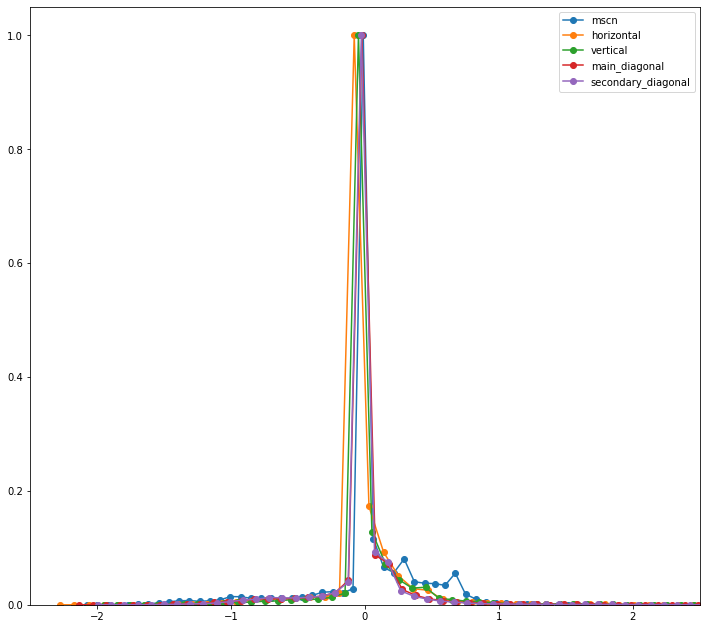

In [0]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 11

for name, coeff in coefficients.items():
  plot_histogram(coeff.ravel(), name)

plt.axis([-2.5, 2.5, 0, 1.05])
plt.legend()
plt.show()

In [0]:
%%time 

brisque_features = calculate_brisque_features(gray_image, kernel_size=7, sigma=7/6)

CPU times: user 32.2 ms, sys: 190 µs, total: 32.4 ms
Wall time: 35.4 ms


In [0]:
%%time

downscaled_image = cv2.resize(gray_image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
downscale_brisque_features = calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)

brisque_features = np.concatenate((brisque_features, downscale_brisque_features))

CPU times: user 10.9 ms, sys: 30 µs, total: 11 ms
Wall time: 33.6 ms


In [0]:
from google.colab import drive
drive.mount('/content/drive')
def scale_features(features):
  with open('/content/drive/My Drive/Colab Notebooks/normalize.pickle', 'rb') as handle:
    scale_params = pickle.load(handle)
    
  min_ = np.array(scale_params['min_'])
  max_ = np.array(scale_params['max_'])
  
  return -1 + (2.0 / (max_ - min_) * (features - min_))

def calculate_image_quality_score(brisque_features):
  model = svmutil.svm_load_model('/content/drive/My Drive/Colab Notebooks/brisque_svm.txt')
  scaled_brisque_features = scale_features(brisque_features)
  
  x, idx = svmutil.gen_svm_nodearray(
      scaled_brisque_features,
      isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))
  
  nr_classifier = 1
  prob_estimates = (svmutil.c_double * nr_classifier)()
  
  return svmutil.libsvm.svm_predict_probability(model, x, prob_estimates)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%time

calculate_image_quality_score(brisque_features)

CPU times: user 9.69 ms, sys: 1.77 ms, total: 11.5 ms
Wall time: 1.35 s


98.95354639051547